Quipper is a high-level programming language for quantum computing, presented at PLDI in 2023 (see 
<a href="https://dl.acm.org/doi/10.1145/2491956.2462177">ACM Digital Library</a> and 
<a href="https://www.mathstat.dal.ca/~selinger/quipper/">Quipper project page</a> for details).
<br> Files written in Quipper used in this code are from <a href="https://github.com/njross/optimizer">the author's GitHub</a>. His publication on quantum circuit optimization using continous parameters is available at <a href="https://www.nature.com/articles/s41534-018-0072-4">npj quantum information</a>.

In [25]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.quantum_info import state_fidelity

In [3]:
# -------------------------------
# Parser for Quipper ASCII format
# -------------------------------
def parse_quipper_ascii(filename):
    ops = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("Comment"):
                continue

            # Hadamard gate
            if line.startswith('QGate["H"]'):
                idx = int(line.split("(")[-1].split(")")[0])
                ops.append(("H", [idx], []))

            # NOT gate (PauliX or CNOT)
            elif line.startswith('QGate["not"]'):
                target = int(line.split("(")[-1].split(")")[0])
                if "controls" in line:
                    ctrl = int(line.split("controls=[+")[1].split("]")[0])
                    ops.append(("CNOT", [ctrl, target], []))
                else:
                    ops.append(("X", [target], []))

            # Z rotations
            elif line.startswith('QRot["exp(-i%Z)"'):
                angle_str = line.split(",")[1].split("]")[0]
                angle = float(angle_str)
                idx = int(line.split("(")[-1].split(")")[0])
                ops.append(("RZ", [idx], [angle]))

    return ops

def quipper_to_qnode(filename, wires=8):
    ops = parse_quipper_ascii(filename)
    dev = qml.device("default.qubit", wires=wires)

    @qml.qnode(dev)
    def circuit():
        for name, ws, params in ops:
            if name == "H":
                qml.Hadamard(wires=ws[0])
            elif name == "X":
                qml.PauliX(wires=ws[0])
            elif name == "CNOT":
                qml.CNOT(wires=ws)
            elif name == "RZ":
                qml.RZ(params[0], wires=ws[0])
        return qml.state()

    return circuit


In [4]:
path = "datasets/QFT_and_Adders/QFT/"
files = sorted(os.listdir(path))
for f in files:
    print(f)

QFT1024_after
QFT1024_before
QFT128_after
QFT128_before
QFT16_after
QFT16_before
QFT2048_after
QFT2048_before
QFT256_after
QFT256_before
QFT32_after
QFT32_before
QFT512_after
QFT512_before
QFT64_after
QFT64_before
QFT8_after
QFT8_before


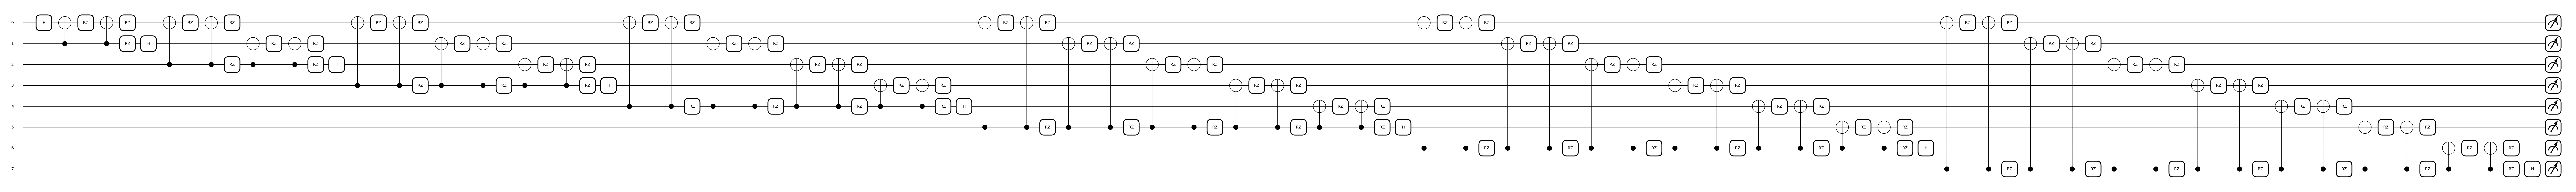

In [5]:
filename = path + "QFT8_before"
qnode1 = quipper_to_qnode(filename, wires=8)

fig, ax = qml.draw_mpl(qnode1)()
plt.show()

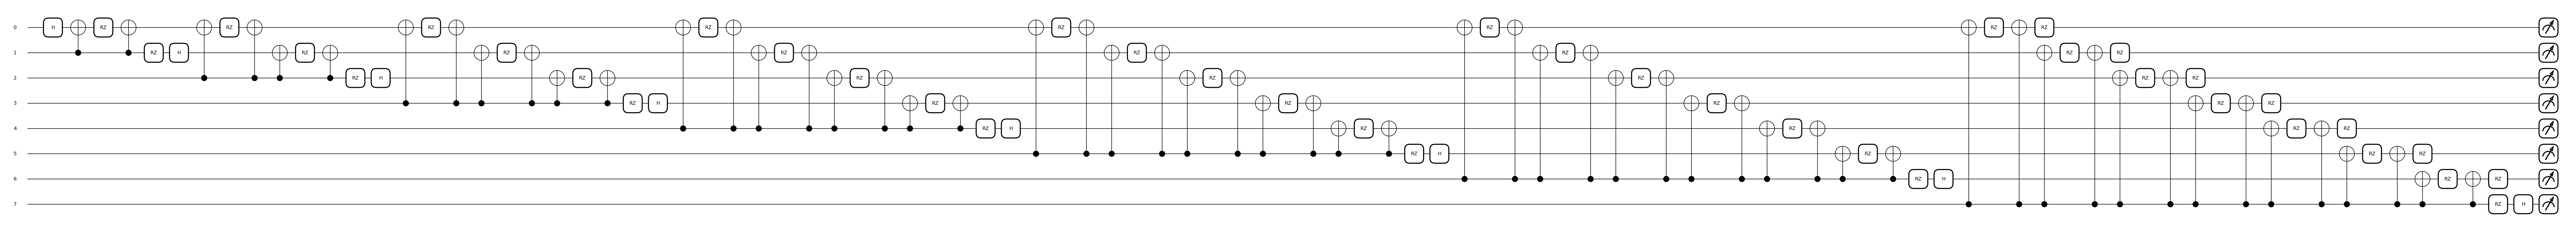

In [6]:
filename = path + "QFT8_after"
qnode2 = quipper_to_qnode(filename, wires=8)

fig, ax = qml.draw_mpl(qnode2)()
plt.show()

In [ ]:
def state_fidelity(psi1, psi2):
    rho1 = np.outer(psi1, np.conj(psi1)) 
    rho2 = np.outer(psi2, np.conj(psi2)) 

    fid = qml.math.fidelity(rho1, rho2)
    return round(fid,3)

state_fidelity(qnode1(), qnode2())

np.float64(1.0)

How to save quantum circuits in OpenQASM and load it as qc in Qiskit

In [8]:
# save it to OpenQASM
qasm_str = qml.to_openqasm(qnode1)()
with open("qft8.qasm", "w") as f: 
    f.write(qasm_str)

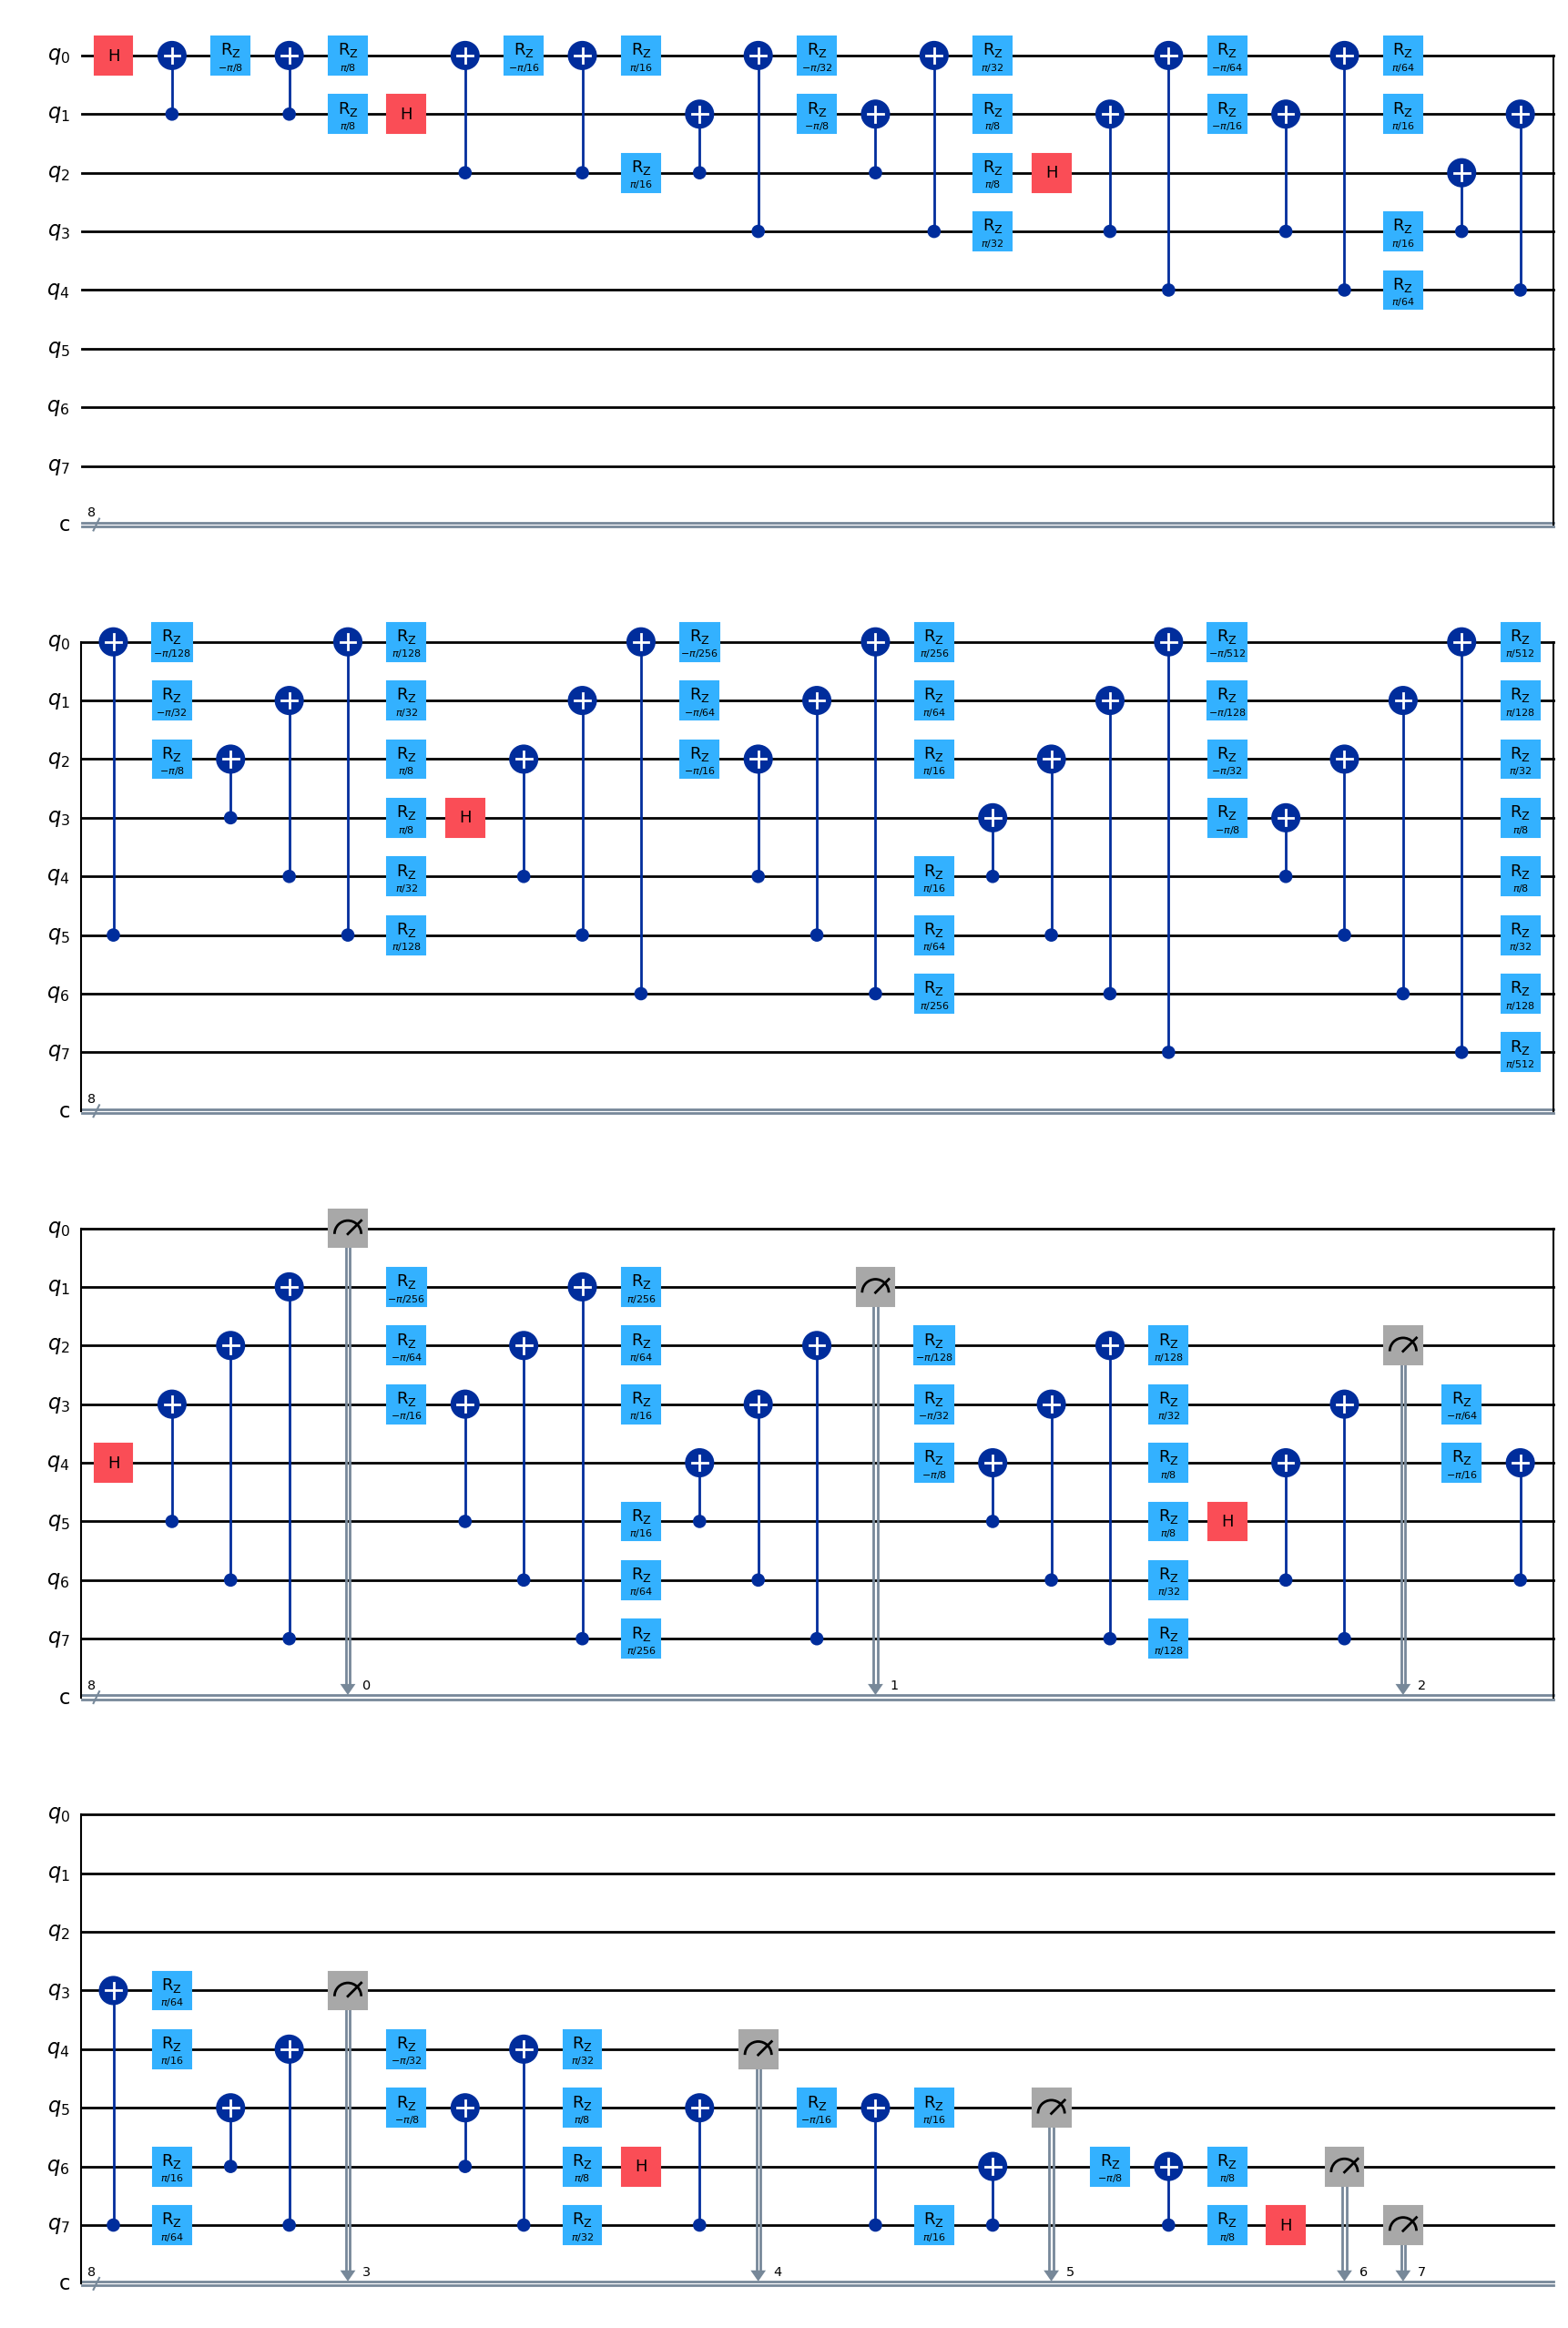

In [9]:

qc = QuantumCircuit.from_qasm_file("qft8.qasm")
qc.draw("mpl")

Compare transplied circuits by Nam's approach and Qiskit

In [10]:
def spec_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    return [obj.num_gates, obj.gate_sizes[1], obj.gate_sizes[2], obj.depth]

def spec_qiskit(qc):
    counts = {'1q': 0, '2q': 0}
    for gate in qc.data:
        if len(gate.qubits) == 1:
            counts['1q'] += 1
        elif len(gate.qubits) == 2:  
            counts['2q'] += 1
    return [qc.size(), counts['1q'], counts['2q'], qc.depth()]

qc_transpiled = transpile(qc, optimization_level=3)

df = pd.DataFrame(columns=['Nam','Qiskit'])
df['Nam'] = spec_penny(qnode2)
df['Qiskit'] = spec_qiskit(qc_transpiled)
df.index = ['Gate count', 'Single-qubit gate count', 'Two-qubit gate count','Circuit depth']
df

,Nam,Qiskit
Gate count,106,127
Single-qubit gate count,50,71
Two-qubit gate count,56,56
Circuit depth,42,49


In [ ]:
# Strip measurements before extracting the statevector
qc_no_measure1 = qc.remove_final_measurements(inplace=False)
qc_no_measure2 = qc_transpiled.remove_final_measurements(inplace=False)

# get statevectors
st1 = Statevector.from_instruction(qc_no_measure1)
st2 = Statevector.from_instruction(qc_no_measure2)

round(state_fidelity(st1, st2),3)

0.95